In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [ ]:
#Data stuff happens here
time_res = 2000
t_fine = np.linspace(0,76,time_res)

url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

raw_years = df.index.to_numpy()  # [1845, ..., 1921]
shifted_years = raw_years - raw_years[0]  # [0, ..., 76

hares = df['Hare']
lynxes = df['Lynx']

hares_interp = interp1d(shifted_years, hares, kind='cubic')
lynxes_interp = interp1d(shifted_years, lynxes, kind='cubic')

hares_fine = hares_interp(t_fine)
lynxes_fine = lynxes_interp(t_fine)

data = np.array([hares_fine, lynxes_fine]).T

data_test = data[:100]
data_train = data[100:]

t_fine_test = t_fine[:100]
t_fine_train = t_fine[100:]

<ipython-input-3-3829284712>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# prompt: with the above data, make a simple parameter learner that learns the four parameters of the LV model

class LV(nn.Module):

    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.1))
        self.b = nn.Parameter(torch.tensor(0.01))
        self.g = nn.Parameter(torch.tensor(0.4))
        self.d = nn.Parameter(torch.tensor(0.005))

    def forward(self, t, y):
        # y = [H, L]
        H = y[0]
        L = y[1]
        dHdt = self.a * H - self.b * H * L
        dLdt = self.d * H * L - self.g * L
        return torch.stack([dHdt, dLdt])

# Convert data to tensor and normalize
data_tensor = torch.tensor(data_train, dtype=torch.float32,device=device)

# Create the model
model = LV()
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Integrate the ODE
    pred_y = odeint(model, data_tensor[0], torch.tensor(t_fine_train, dtype=torch.float32),method='dopri5')

    # Calculate loss (Mean Squared Error)
    loss = torch.mean((pred_y - data_tensor)**2)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




Epoch [10/1000], Loss: 1939.6653
Epoch [20/1000], Loss: 1927.8925
Epoch [30/1000], Loss: 1600.7621
Epoch [40/1000], Loss: 1418.8547
Epoch [50/1000], Loss: 1596.3292
Epoch [60/1000], Loss: 1658.4177
Epoch [70/1000], Loss: 1618.4869
Epoch [80/1000], Loss: 1559.9247
Epoch [90/1000], Loss: 1507.0422
Epoch [100/1000], Loss: 1499.4244
Epoch [110/1000], Loss: 1481.8965
Epoch [120/1000], Loss: 1467.9457
Epoch [130/1000], Loss: 1451.0338
Epoch [140/1000], Loss: 1432.2819
Epoch [150/1000], Loss: 1410.7184
Epoch [160/1000], Loss: 1385.2599
Epoch [170/1000], Loss: 1354.4774
Epoch [180/1000], Loss: 1315.7950
Epoch [190/1000], Loss: 1264.1581
Epoch [200/1000], Loss: 1186.9771
Epoch [210/1000], Loss: 1091.6991
Epoch [220/1000], Loss: 1085.4181
Epoch [230/1000], Loss: 1083.7247
Epoch [240/1000], Loss: 1080.1512
Epoch [250/1000], Loss: 1077.8706
Epoch [260/1000], Loss: 1076.4059
Epoch [270/1000], Loss: 1074.6462
Epoch [280/1000], Loss: 1072.8976
Epoch [290/1000], Loss: 1070.9945
Epoch [300/1000], Loss:

AttributeError: 'LV' object has no attribute 'c'

In [ ]:
print("\nLearned Parameters:")
print(f"a: {model.a.item():.4f}")
print(f"b: {model.b.item():.4f}")
print(f"c: {model.g.item():.4f}")
print(f"d: {model.d.item():.4f}")


Learned Parameters:
a: 0.2385
b: 0.0094
c: 0.3052
d: 0.0076


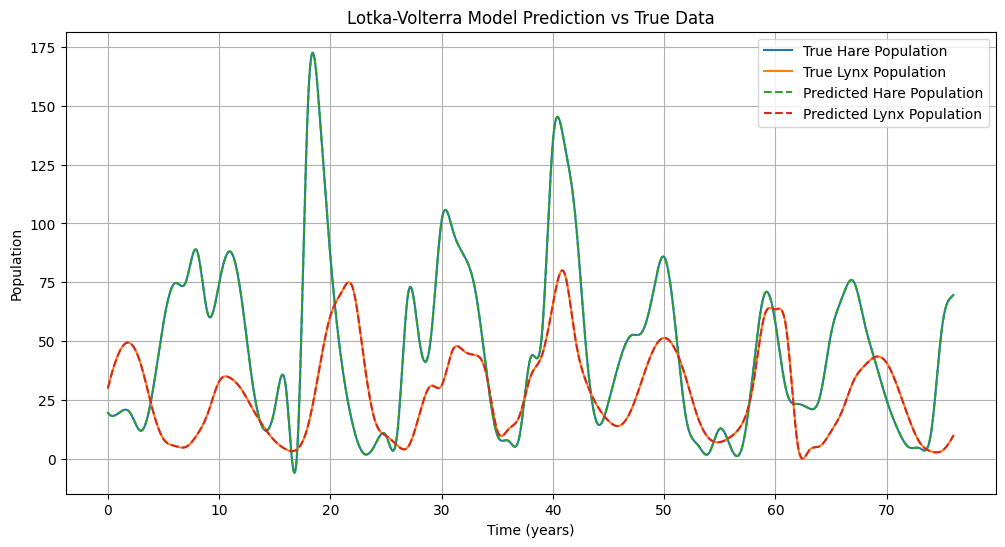

In [ ]:
# prompt: Graph the results against true data

import numpy as np
import matplotlib.pyplot as plt

# Predict the solution using the trained model
with torch.no_grad():
    predicted_data_norm = odeint(model, data_tensor[0], torch.tensor(t_fine, dtype=torch.float32)).numpy()

# Denormalize the predicted data
predicted_data = data

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(t_fine, hares_fine, label='True Hare Population')
plt.plot(t_fine, lynxes_fine, label='True Lynx Population')
plt.plot(t_fine, predicted_data[:, 0], linestyle='--', label='Predicted Hare Population')
plt.plot(t_fine, predicted_data[:, 1], linestyle='--', label='Predicted Lynx Population')

plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.title('Lotka-Volterra Model Prediction vs True Data')
plt.legend()
plt.grid(True)
plt.show()